In [2]:
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from tqdm import tqdm


/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
from MDAnalysis.transformations import wrap
from MDAnalysis import transformations as trans

In [4]:
# 1,2 and 3 과정을 한번에 하기
import MDAnalysis.transformations as trans

md_universe = mda.Universe(str("./240822_Final_topology_50ns_PME_2.pdb"), str("./240822_Final_trajectory_50ns_PME_2.xtc"))

protein = md_universe.select_atoms("protein")
not_protein = md_universe.select_atoms("not protein")

transforms = [trans.unwrap(protein),
              trans.center_in_box(protein),
              trans.wrap(not_protein)]

md_universe.trajectory.add_transformations(*transforms)

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:287: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [5]:
with mda.Writer("20240822_df_rank2_wrap_1_rmsd.xtc", md_universe.atoms.n_atoms) as W:
    for ts in tqdm(md_universe.trajectory, desc="Writing trajectory..."):
        W.write(md_universe.atoms)


Writing trajectory...: 100%|██████████| 50000/50000 [29:48<00:00, 27.96it/s]  


In [6]:
transformed_universe = mda.Universe(str("./240822_Final_topology_50ns_PME_2.pdb"), str("./20240822_df_rank2_wrap_1_rmsd.xtc"))

In [7]:
# Set trajectory pointer to first frame as reference
transformed_universe.trajectory[0]

< Timestep 0 with unit cell dimensions [86.17446 86.17446 86.17446 90.      90.      90.     ] >

In [8]:
# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe

alignment_2 = align.AlignTraj(
    mobile=transformed_universe, reference=transformed_universe, select="protein", in_memory=True
)
alignment_2.run()

In [9]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()

    columns = [selection1, *selection2] if selection2 else [selection1]
    #print(rmsd_analysis.results)
    #print(rmsd_analysis)
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "time"
    return rmsd_df

In [10]:
rmsd_2 = rmsd_for_atomgroups(transformed_universe, "backbone", ["protein", "resname UNK"])

In [11]:
rmsd_2.rename(columns={"resname UNK": "rank_2_ligand"}, inplace=True)

In [12]:
rmsd_2.to_csv("./20240822_df_rank2_wrap_1_rmsd.csv", index=False)

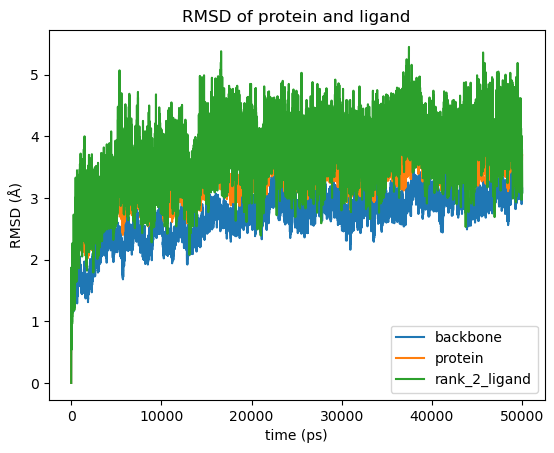

In [13]:
rmsd_2.plot(title="RMSD of protein and ligand")
plt.xlabel("time (ps)")
plt.ylabel("RMSD (Å)");
plt.savefig("20240905_final_rank2_rmsd_for50ns_wrap_1_results") 